In [1]:
!pip install pyjanitor pyvis --quiet

     |████████████████████████████████| 135 kB 22.9 MB/s 


In [2]:
import pandas as pd
import janitor
import datetime

from IPython.core.display import display, HTML
from pyvis import network as net
import networkx as nx

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/DeepL/LinkedIn/Connections.csv", skiprows=2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     150 non-null    object
 1   Last Name      150 non-null    object
 2   Email Address  3 non-null      object
 3   Company        121 non-null    object
 4   Position       122 non-null    object
 5   Connected On   150 non-null    object
dtypes: object(6)
memory usage: 7.2+ KB


In [8]:
df.head()

,First Name,Last Name,Email Address,Company,Position,Connected On
0,Neha,Kulkarni,NaN,NaN,NaN,10 Mar 2022
1,Pramila,Balan,NaN,Cybage Software,Sr. Content Writer,10 Mar 2022
2,Deepika,Velusamy,NaN,Solsten Data Consulting Private Limited,Data Engineer,10 Mar 2022
3,Nikhil,Sharma,NaN,Ganit Inc.,Data Analyst,10 Mar 2022
4,Rohan,Pardeshi,NaN,Milkbasket,Data Analyst,09 Mar 2022


## Data Cleaning

In [9]:
df_org = (
    df
    .clean_names() # remove spacing and capitalization
    .drop(columns=['first_name', 'last_name', 'email_address']) # drop for privacy
    .dropna(subset=['company', 'position']) # drop missing values in company and position
    .to_datetime('connected_on', format='%d %b %Y')
  )
df_org.head()

,company,position,connected_on
1,Cybage Software,Sr. Content Writer,2022-03-10
2,Solsten Data Consulting Private Limited,Data Engineer,2022-03-10
3,Ganit Inc.,Data Analyst,2022-03-10
4,Milkbasket,Data Analyst,2022-03-09
5,Aadhar Housing Finance Ltd.,Data Scientist,2022-03-09


In [10]:
df_org.shape

(121, 3)

## Simple EDA

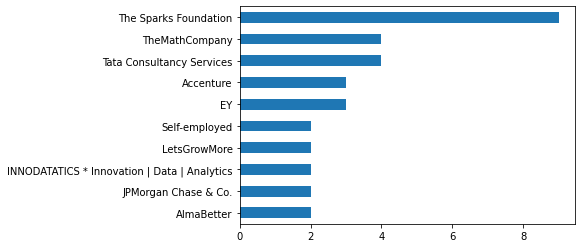

In [11]:
df_org['company'].value_counts().head(10).plot(kind="barh").invert_yaxis();

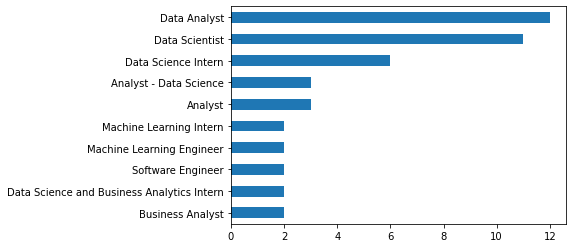

In [12]:
df_org['position'].value_counts().head(10).plot(kind="barh").invert_yaxis();

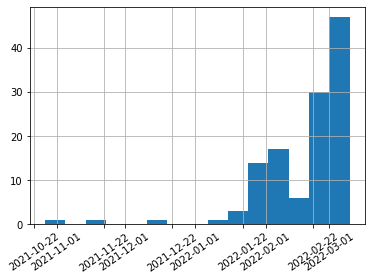

In [13]:
df_org['connected_on'].hist(xrot=35, bins=15);

### Remove freelance and self-employed titles

In [14]:
pattern = "freelance|self-employed"
df = df_org[~df_org['company'].str.contains(pattern, case=False)]

## Aggregate sum of connections for companies

In [15]:
df_company = df['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head(10)

,company,count
0,The Sparks Foundation,9
2,Tata Consultancy Services,4
1,TheMathCompany,4
3,Accenture,3
4,EY,3
7,JPMorgan Chase & Co.,2
8,AlmaBetter,2
9,LetsGrowMore,2
6,Tiger Analytics,2
5,INNODATATICS * Innovation | Data | Analytics,2


## Aggregate sum of connections for positions

In [16]:
df_position = df['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head(10)

,position,count
0,Data Analyst,12
1,Data Scientist,11
2,Data Science Intern,6
3,Analyst,3
4,Analyst - Data Science,3
7,Data Science and Business Analytics Intern,2
8,Software Engineer,2
9,Machine Learning Intern,2
6,Machine Learning Engineer,2
5,Business Analyst,2


## Creating the network

### Example of simple network

In [17]:
nt = net.Network(notebook=True)

g = nx.Graph()
g.add_node(0, label = "root") # intialize yourself as central node
g.add_node(1, label = "Company 1", size=10, title="info1")
g.add_node(2, label = "Company 2", size=40, title="info2")
g.add_node(3, label = "Company 3", size=60, title="info3")
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(0, 3)

nt.from_nx(g)
nt.show('nodes.html')
display(HTML('nodes.html'))

In [18]:
print(f"number of nodes: {g.number_of_nodes()}")
print(f"number of edges: {g.number_of_edges()}")

number of nodes: 4
number of edges: 3


In [19]:
for _, row in df_company.head(5).iterrows():
  print(row['company'] + "-" + str(row['count']))

The Sparks Foundation-9
Tata Consultancy Services-4
TheMathCompany-4
Accenture-3
EY-3


In [20]:
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=5]
print(df_company_reduced.shape)

(96, 2)
(1, 2)


In [21]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=5]
print(df_position_reduced.shape)

(84, 2)
(3, 2)


In [22]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_company_reduced.iterrows():

  # store company name and count
  company = row['company']
  count = row['count']

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
from google.colab import files
files.download('company_graph.html') 
display(HTML('company_graph.html'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_position_reduced.iterrows():

  count = f"{row['count']}"
  position= row['position']
  
  g.add_node(position, size=count, color='#3449eb', title=count)
  g.add_edge('root', position, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('position_graph.html')
from google.colab import files
files.download('position_graph.html') 
display(HTML('position_graph.html'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Publish to datapane

In [24]:
# credits to Khuyen Tran
def read_html(name: str):
    import codecs
    f = codecs.open(name, 'r')
    return f.read()

In [25]:
!pip install jupyter-client==6.1.5 datapane --quiet
import datapane as dp

     |████████████████████████████████| 107 kB 16.5 MB/s 
     |████████████████████████████████| 2.6 MB 56.1 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 23.6 MB 3.9 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 49.0 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 193 kB 50.6 MB/s 
     |████████████████████████████████| 10.9 MB 44.7 MB/s 
     |████████████████████████████████| 46 kB 3.2 MB/s 


In [26]:
!datapane login --server=https://datapane.com/ --token='360934c84f181098a1814f2498710a8ca2ae9679'

Connected successfully to https://datapane.com as aniket15


In [27]:
r = dp.Report(
  dp.HTML(read_html('company_graph.html'))
) 

r2 = dp.Report(
  dp.HTML(read_html('position_graph.html'))
)

r3 = dp.Report(
  dp.HTML(read_html('nodes.html'))
)

r.upload(name='linkedin_connection_company')
r2.upload(name='linkedin_connection_positions')
r3.upload(name='sample_graph')

Uploading report and associated data - *please wait...*
Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? More info at https://docs.datapane.com/reports/blocks/layout-pages-and-selects
Report successfully uploaded. View and share your report at https://datapane.com/u/aniket15/reports/dkjKoVA/linkedin-connection-company/, or edit your report at https://datapane.com/u/aniket15/reports/dkjKoVA/linkedin-connection-company/edit/.
Uploading report and associated data - *please wait...*
Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? More info at https://docs.datapane.com/reports/blocks/layout-pages-and-selects
Report successfully uploaded. View and share your report at https://datapane.com/u/aniket15/reports/R706g6A/linkedin-connection-positions/, or edit your report at https://datapane.com/u/aniket15/reports/R706g6A/linkedin-connection